In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('CC.tsv', header = 0, sep = "\t")

In [4]:
df = df.dropna()

In [5]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"
5,10224742,HY411435,09/05/2015 10:55:00 AM,082XX S LOOMIS BLVD,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,...,21.0,71.0,05,1168430.0,1850165.0,2015,02/10/2018 03:50:01 PM,41.744379,-87.658431,"(41.744378879, -87.658430635)"


In [6]:
df.shape

(6604676, 22)

In [7]:
# Dropping attributes that are redundant (ID,Case Number) - unique value for each crime record
# Updated on - not useful in analysis
# X,Y Coordinate/Latitude/Longitude - specific geographical location for each record

df = df.drop(columns=['ID', 'Case Number', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude', 'Location'])

In [8]:
df.shape

(6604676, 14)

In [9]:
df.dtypes

Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
Year                      int64
dtype: object

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Month Name'] = pd.DatetimeIndex(df['Date']).month_name()
df['Day'] = pd.DatetimeIndex(df['Date']).day
df['Day Name'] = pd.DatetimeIndex(df['Date']).day_name()
df['Day of Week'] = pd.DatetimeIndex(df['Date']).dayofweek
df['Hour'] = pd.DatetimeIndex(df['Date']).hour
df = df.drop(columns=['Date'])
# Year column not split as already exists in dataset

In [11]:
df_commarea = pd.read_csv('Community Area Names.csv')
df = df.merge(df_commarea, how='left', on='Community Area')
df = df[df.columns[:20]]

In [12]:
df.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Month,Month Name,Day,Day Name,Day of Week,Hour,Community Area Name
0,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,2015,9,September,5,Saturday,5,13,New City
1,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,2015,9,September,4,Friday,4,11,Austin
2,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,2015,9,September,5,Saturday,5,12,Avondale
3,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,2015,9,September,5,Saturday,5,13,Austin
4,082XX S LOOMIS BLVD,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,614,6.0,21.0,71.0,05,2015,9,September,5,Saturday,5,10,Auburn Gresham


In [13]:
df = df.astype({'District': 'int64', 'Ward': 'int64', 'Community Area': 'int64'})
df.dtypes

Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                    bool
Domestic                  bool
Beat                     int64
District                 int64
Ward                     int64
Community Area           int64
FBI Code                object
Year                     int64
Month                    int64
Month Name              object
Day                      int64
Day Name                object
Day of Week              int64
Hour                     int64
Community Area Name     object
dtype: object

In [14]:
df_grouped_types = df.replace(['THEFT', 'MOTOR VEHICLE THEFT', 'DECEPTIVE PRACTICE', 'ROBBERY', 'BURGLARY', 'KIDNAPPING'], 'Theft')
df_grouped_types = df_grouped_types.replace(['CRIMINAL DAMAGE', 'ARSON', 'CRIMINAL TRESPASS'], 'Property')
df_grouped_types = df_grouped_types.replace(['ASSAULT', 'BATTERY', 'INTIMIDATION', 'HOMICIDE'], 'Assault')
df_grouped_types = df_grouped_types.replace(['NARCOTICS', 'LIQUOR LAW VIOLATION', 'GAMBLING', 'OTHER NARCOTIC VIOLATION'], 'Addiction')
df_grouped_types = df_grouped_types.replace(['WEAPONS VIOLATION', 'CONCEALED CARRY LICENSE VIOLATION'], 'Weapons')
df_grouped_types = df_grouped_types.replace(['SEX OFFENSE', 'CRIMINAL SEXUAL ASSAULT', 'CRIM SEXUAL ASSAULT', 'OBSCENITY', 'PROSTITUTION', 'PUBLIC INDECENCY'], 'Sexual')
df_grouped_types = df_grouped_types.replace(['OTHER OFFENSE', 'INTERFERENCE WITH PUBLIC OFFICER', 'OFFENSE INVOLVING CHILDREN', 'STALKING', 'PUBLIC PEACE VIOLATION', 'HUMAN TRAFFICKING', 'NON-CRIMINAL', 'NON - CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM'], 'Others')
df_grouped_types.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Month,Month Name,Day,Day Name,Day of Week,Hour,Community Area Name
0,043XX S WOOD ST,0486,Assault,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9,12,61,08B,2015,9,September,5,Saturday,5,13,New City
1,008XX N CENTRAL AVE,0870,Theft,POCKET-PICKING,CTA BUS,False,False,1511,15,29,25,06,2015,9,September,4,Friday,4,11,Austin
2,035XX W BARRY AVE,2023,Addiction,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14,35,21,18,2015,9,September,5,Saturday,5,12,Avondale
3,0000X N LARAMIE AVE,0560,Assault,SIMPLE,APARTMENT,False,True,1522,15,28,25,08A,2015,9,September,5,Saturday,5,13,Austin
4,082XX S LOOMIS BLVD,0610,Theft,FORCIBLE ENTRY,RESIDENCE,False,False,614,6,21,71,05,2015,9,September,5,Saturday,5,10,Auburn Gresham


In [15]:
# Convert Categorical Attributes to Numerical
df_grouped_types_factorized = df_grouped_types.copy()
df_grouped_types_factorized['Primary Type'] = pd.factorize(df_grouped_types_factorized["Primary Type"])[0] 
df_grouped_types_factorized['Block'] = pd.factorize(df_grouped_types_factorized["Block"])[0]
df_grouped_types_factorized['IUCR'] = pd.factorize(df_grouped_types_factorized["IUCR"])[0]
df_grouped_types_factorized['Description'] = pd.factorize(df_grouped_types_factorized["Description"])[0]
df_grouped_types_factorized['Location Description'] = pd.factorize(df_grouped_types_factorized["Location Description"])[0]
df_grouped_types_factorized['FBI Code'] = pd.factorize(df_grouped_types_factorized["FBI Code"])[0]

In [16]:
df_grouped_types_factorized = df_grouped_types_factorized.drop(columns=['Month Name', 'Day Name', 'Community Area Name'])

In [17]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(df_grouped_types_factorized.drop(columns=['Primary Type']), 
                                                    df_grouped_types_factorized['Primary Type'], 
                                                    test_size=0.30, 
                                                    random_state=69)

In [41]:
# Building CART model with default settings

decision_tree = DecisionTreeClassifier(random_state=69)
decision_tree_model = decision_tree.fit(X_train, y_train)

# Trainset Accuracy

trainset_pred = decision_tree_model.predict(X_train)
train_acc = round(accuracy_score(y_train,trainset_pred)*100,2)

# Testset Accuracy

y_pred = decision_tree_model.predict(X_test)
test_acc = round(accuracy_score(y_test,y_pred)*100,4)

print("CART - Classification Tree")
print("Default parameter settings")
print("============================")
print("Train-set accuracy: " + str(train_acc) + "%")
print("Test-set accuracy: " + str(test_acc) + "%")

CART - Classification Tree
Default parameter settings
Train-set accuracy: 100.0%
Test-set accuracy: 99.9975%


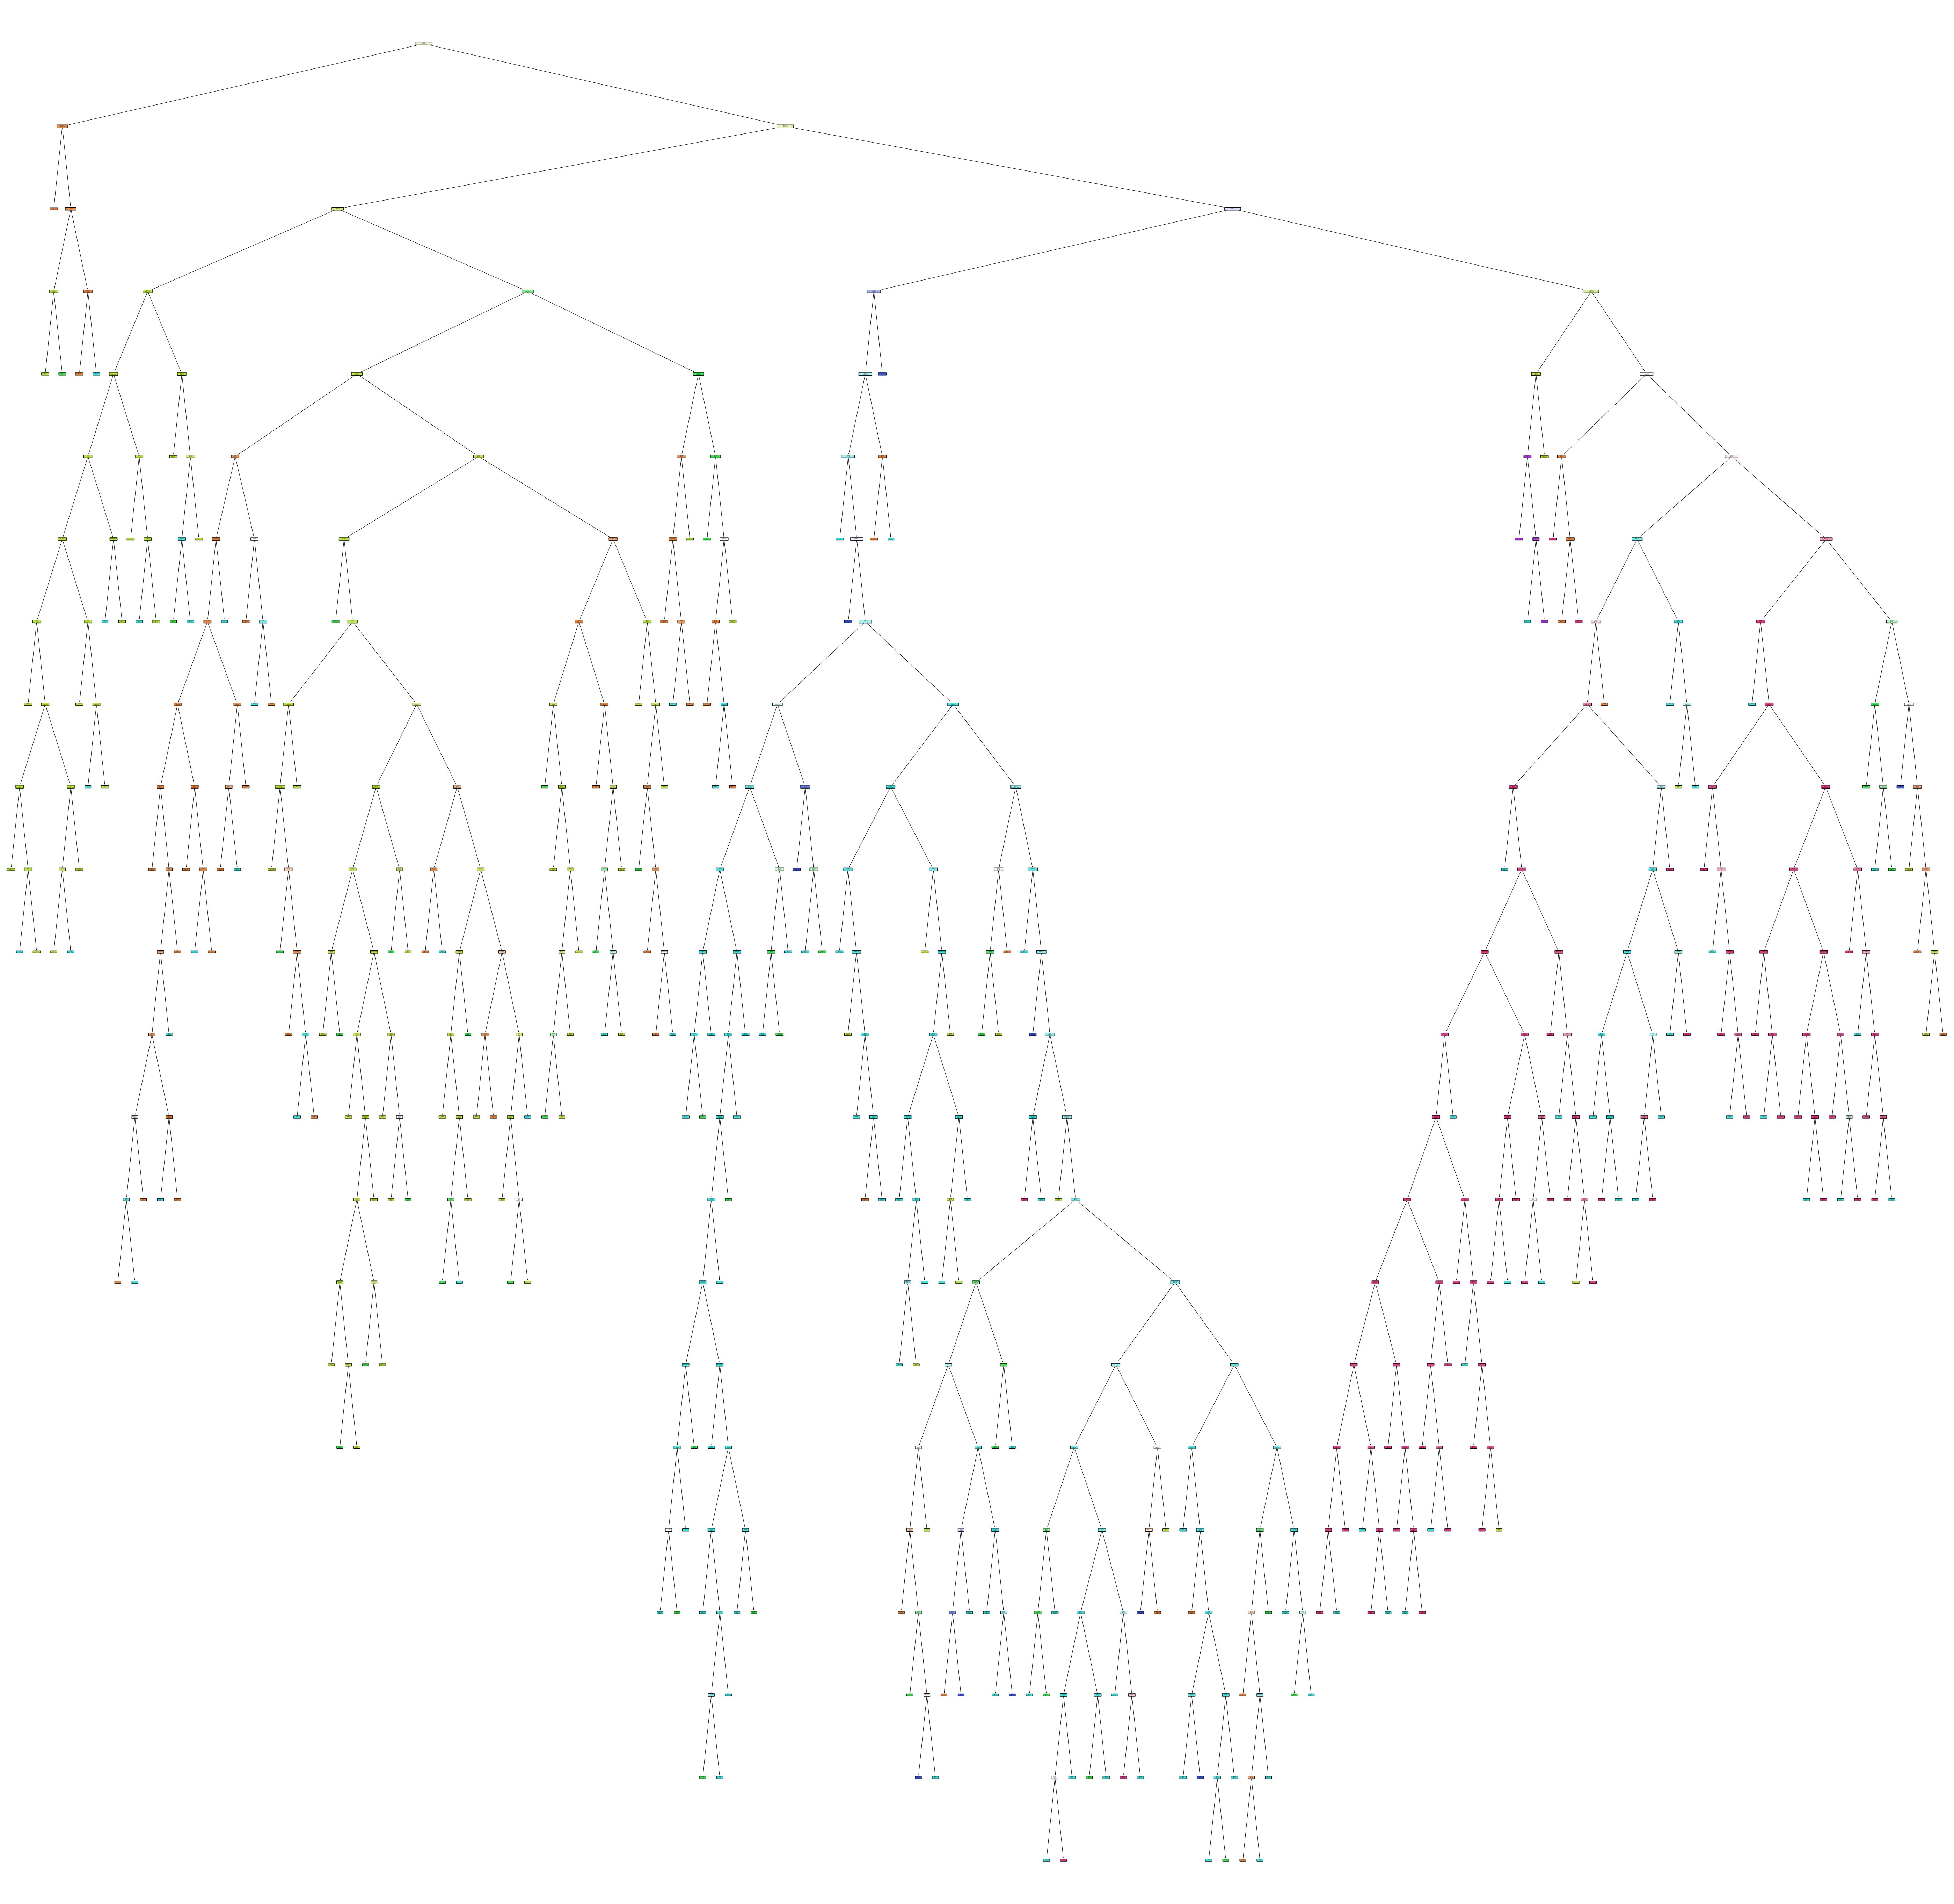

In [51]:
plt.figure(figsize = (100,100))
_ = plot_tree(decision_tree_model, feature_names = X_train.columns, class_names = ['0','1','2','3','4','5','6'], filled = True, 
              rounded = True, node_ids = True)
plt.show()

In [42]:
# Number of nodes in fully grown tree

no_of_nodes_full_tree = decision_tree_model.tree_.node_count
no_of_nodes_full_tree

549

In [46]:
# Max Depth value of fully grown tree

max_depth_full_tree = decision_tree_model.tree_.max_depth
max_depth_full_tree

22

In [110]:
# Post pruning using cost complexity parameter, ccp_alpha

clf = DecisionTreeClassifier(random_state=69)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

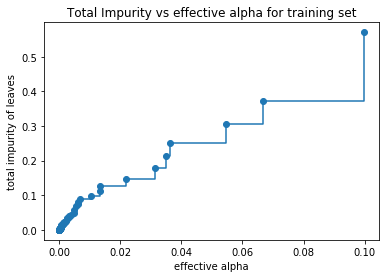

In [111]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [114]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=69, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1740333331177516


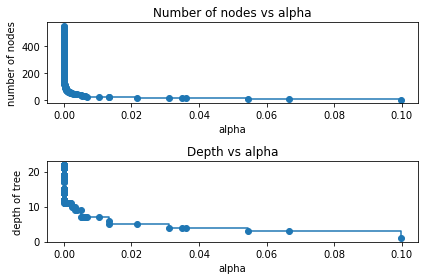

In [115]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

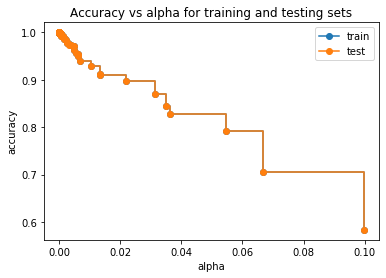

In [116]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [20]:
# Fitting final model with optimal ccp_alpha value

final_model = DecisionTreeClassifier(random_state = 69, ccp_alpha = 1.03805290e-02)
final_model.fit(X_train, y_train)

94.01898553701594

In [40]:
# Variable Importance for CART

print(dict(zip(X_train.columns, final_model.feature_importances_)))

{'Block': 0.0, 'IUCR': 0.17303792111196564, 'Description': 0.3014449798611533, 'Location Description': 0.0, 'Arrest': 0.05345327906499167, 'Domestic': 0.0, 'Beat': 0.0, 'District': 0.0, 'Ward': 0.0, 'Community Area': 0.0, 'FBI Code': 0.4720638199618894, 'Year': 0.0, 'Month': 0.0, 'Day': 0.0, 'Day of Week': 0.0, 'Hour': 0.0}


In [24]:
print("CART - Classification Tree")
print("Pruned using ccp_alpha = 1.03805290e-02")
print("============================")
print("Train-set Accuracy: "+ str(round(final_model.score(X_train,y_train)*100, 2)) + "%")
print("Test-set Accuracy: "+ str(round(final_model.score(X_test,y_test)*100, 2)) + "%")

CART - Classification Tree
Pruned using ccp_alpha = 1.03805290e-02
Train-set Accuracy: 94.04%
Test-set Accuracy: 94.02%


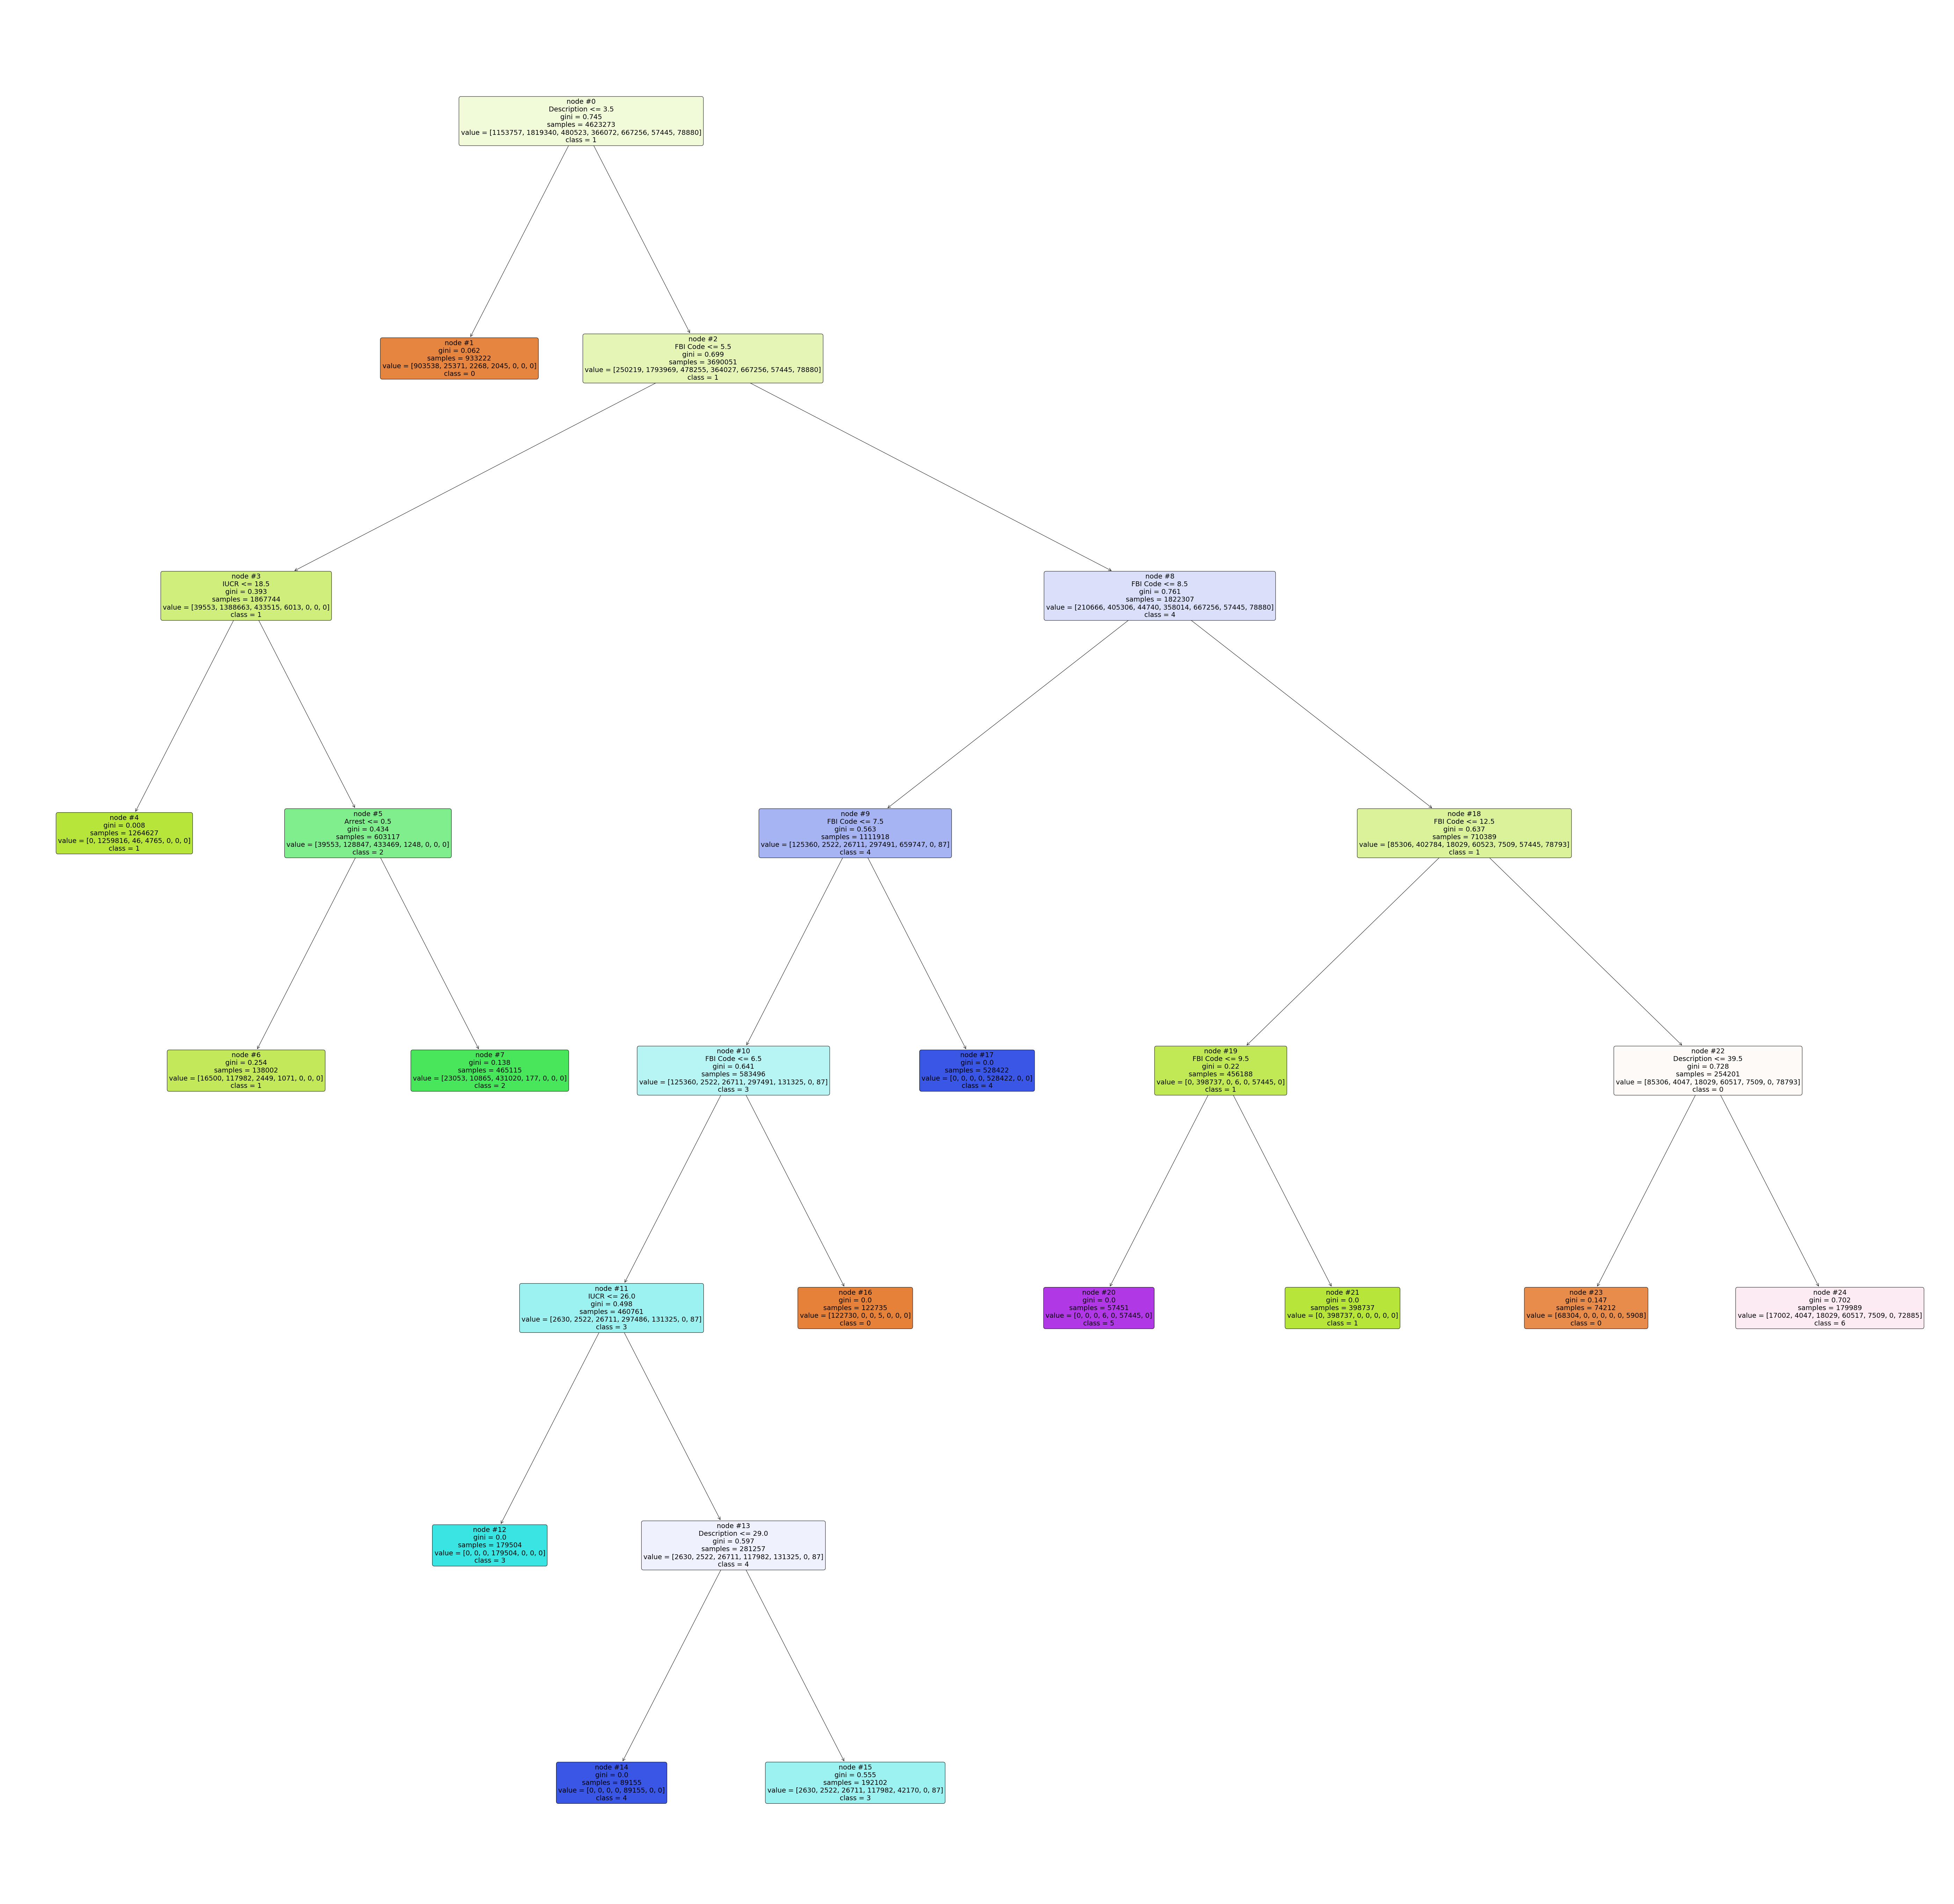

In [29]:
plt.figure(figsize = (100,100))
_ = plot_tree(final_model, feature_names = X_train.columns, class_names = ['0','1','2','3','4','5','6'], filled = True, 
              rounded = True, node_ids = True)
plt.savefig('final_crime_cart.png')
plt.show()

In [48]:
# Number of nodes in fjnal pruned tree

no_of_nodes_pruned_tree = final_model.tree_.node_count
no_of_nodes_pruned_tree

25

In [49]:
# Max Depth value of final pruned tree

max_depth_pruned_tree = final_model.tree_.max_depth
max_depth_pruned_tree

7